## Start up

In [2]:
import pandas as pd
import seaborn as sns
from enum import Enum     # for enum34, or the stdlib version
from pycaret.classification import *
from anonymizeip import anonymize_ip

class AnonTypes(Enum):
    BM = 0 # black marker 
    BI = 1 # bilateral classification
    NO = 2 # no anonymization
    
sample = 0
binary = 1

# anonymization flag
tlp_anonymization = AnonTypes.NO
ip_proto_anonymization = AnonTypes.NO
pkt_counter_anonymization = AnonTypes.NO
oct_counter_anonymization = AnonTypes.NO

In [3]:
from typing import List

def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            if not (type(df[col][0])==list):
                num_unique_values = len(df[col].unique())
                num_total_values = len(df[col])
                if float(num_unique_values) / num_total_values < 0.5:
                    df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df



def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))

In [4]:
df = pd.read_csv("../../NF-ToN-IoT.csv")

## Checks

### =================================================================

In [5]:
# Remove non-ipfix standardized features
# See: https://www.ntop.org/guides/nprobe/cli_options.html#netflow-v9-ipfix-format-t
# Thesis: Refer to table 2 for feature names and descriptions

df_ipfix = df[['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack']]
#df_ipfix['IPV4_SRC_ADDR'] = df_ipfix['IPV4_SRC_ADDR'].astype('category')
#df_ipfix['IPV4_DST_ADDR'] = df_ipfix['IPV4_DST_ADDR'].astype('category')

df_ipfix = optimize(df_ipfix, [])
df_ipfix.memory_usage()

Index                             128
L4_SRC_PORT                   5517096
L4_DST_PORT                   5517096
PROTOCOL                      1379274
IN_BYTES                      5517096
OUT_BYTES                     5517096
IN_PKTS                       5517096
OUT_PKTS                      5517096
TCP_FLAGS                     2758548
FLOW_DURATION_MILLISECONDS    5517096
Label                         1379274
Attack                        1379654
dtype: int64

In [6]:
if(binary):
    df_ = df_ipfix.drop("Attack", axis=1)
else:
    df_ = df_ipfix.drop("Label", axis=1)

# Sample data
if(sample):
    df_ = df_.sample(n=1000000)

## Feature Anonymization Functions

In [7]:
def anon_tlp(anon_type, df):
    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.5.1
        df['L4_SRC_PORT'] = [0 if int(x) <= 1023 else 1 for x in df['L4_SRC_PORT']]
        df['L4_DST_PORT'] = [0 if int(x) <= 1023 else 1 for x in df['L4_DST_PORT']]
    elif(anon_type == AnonTypes.BM):
        df['L4_SRC_PORT'] = 0
        df['L4_DST_PORT'] = 0
 
    return df
    
def anon_pkt_counters(anon_type, df): 
    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.4.2
        df['IN_PKTS'] = [0 if int(x) <= 2 else 1 for x in df['IN_PKTS']]
        df['OUT_PKTS'] = [0 if int(x) <= 2 else 1 for x in df['OUT_PKTS']]
    elif(anon_type == AnonTypes.BM): 
        df['IN_PKTS'] = 0
        df['OUT_PKTS'] = 0
    
    return df

def anon_octet_counters(anon_type, df): 
    mean_bytes_in = round(df_['IN_BYTES'].mean()) 
    mean_bytes_out= round(df_['OUT_BYTES'].mean()) 

    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.4.2
        df['IN_BYTES'] = [0 if int(x) <= mean_bytes_in else 1 for x in df['IN_BYTES']]
        df['OUT_BYTES'] = [0 if int(x) <= mean_bytes_out else 1 for x in df['OUT_BYTES']]
    elif(anon_type == AnonTypes.BM): 
        df['IN_BYTES'] = 0
        df['OUT_BYTES'] = 0
    
    return df

def anon_ip_proto(anon_type, df):
    grouped_protocols = [1, 6, 17] # 1, 6, and 17 for ICMP, UDP, and TCP 

    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.5.1
        df['PROTOCOL'] = [0 if int(x) in grouped_protocols else 1 for x in df['PROTOCOL']] 
    elif(anon_type == AnonTypes.BM): 
        df['PROTOCOL'] = 0
        
    return df

### Anonymization iterations 

In [8]:
#print(df_['L4_SRC_PORT'].value_counts())
df_ = anon_tlp(tlp_anonymization, df_)
df_ = anon_pkt_counters(pkt_counter_anonymization, df_)
df_ = anon_octet_counters(oct_counter_anonymization, df_)
df_ = anon_ip_proto(ip_proto_anonymization, df_)

df_.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label
0,1,0,0,0,0,0,0,24,327,0
1,1,1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0


### =================================================================

## Setup

In [9]:
#df_['ICMP_TYPE'] = df_['ICMP_TYPE'].astype(str)
#df_['ICMP_IPV4_TYPE'] = df_['ICMP_IPV4_TYPE'].astype(str)
categorical = ['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'TCP_FLAGS']

for f in categorical:
    df_[f] = df_[f].astype('str')

#df_ = df_[['TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label']]

if(binary):
    session_binary = setup(df_, target = 'Label', experiment_name='binary', categorical_features = categorical, normalize=True, fix_imbalance=True)
else:
    session_multi = setup(df_, target = 'Attack', experiment_name='multiclass', categorical_features = categorical, normalize=True, fix_imbalance=True)

,Description,Value
0,Session id,2738
1,Target,Label
2,Target type,Binary
3,Original data shape,"(1379274, 10)"
4,Transformed data shape,"(1966375, 10)"
5,Transformed train set shape,"(1552592, 10)"
6,Transformed test set shape,"(413783, 10)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,4


In [10]:
compare_models(sort = 'F1', include=['nb', 'svm', 'dt'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.9670,0.9838,0.9859,0.9734,0.9796,0.8931,0.8936,20.7950
svm,SVM - Linear Kernel,0.9348,0.0000,0.9248,0.9937,0.9580,0.8131,0.8237,2.8030
dt,Decision Tree Classifier,0.9191,0.9024,0.9299,0.9683,0.9487,0.7583,0.7619,2.5640


Processing:   0%|          | 0/17 [00:00<?, ?it/s]

GaussianNB(priors=None, var_smoothing=1e-09)

## SVM 

In [11]:
svm = create_model('svm')
svm_grid = pull()
print(svm_grid)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9352,0.0000,0.9254,0.9935,0.9583,0.8141,0.8245
1,0.9340,0.0000,0.9239,0.9936,0.9575,0.8111,0.8218
2,0.9347,0.0000,0.9247,0.9936,0.9579,0.8129,0.8234
3,0.9352,0.0000,0.9253,0.9936,0.9582,0.8141,0.8245
4,0.9365,0.0000,0.9270,0.9936,0.9592,0.8176,0.8276
5,0.9346,0.0000,0.9249,0.9933,0.9579,0.8126,0.8230
6,0.9359,0.0000,0.9262,0.9936,0.9587,0.8158,0.8261
7,0.9349,0.0000,0.9248,0.9938,0.9580,0.8134,0.8240
8,0.9343,0.0000,0.9244,0.9934,0.9577,0.8118,0.8224


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.9352  0.0  0.9254  0.9935  0.9583  0.8141  0.8245
1       0.9340  0.0  0.9239  0.9936  0.9575  0.8111  0.8218
2       0.9347  0.0  0.9247  0.9936  0.9579  0.8129  0.8234
3       0.9352  0.0  0.9253  0.9936  0.9582  0.8141  0.8245
4       0.9365  0.0  0.9270  0.9936  0.9592  0.8176  0.8276
5       0.9346  0.0  0.9249  0.9933  0.9579  0.8126  0.8230
6       0.9359  0.0  0.9262  0.9936  0.9587  0.8158  0.8261
7       0.9349  0.0  0.9248  0.9938  0.9580  0.8134  0.8240
8       0.9343  0.0  0.9244  0.9934  0.9577  0.8118  0.8224
9       0.9325  0.0  0.9210  0.9946  0.9564  0.8078  0.8197
Mean    0.9348  0.0  0.9248  0.9937  0.9580  0.8131  0.8237
Std     0.0010  0.0  0.0015  0.0003  0.0007  0.0025  0.0021


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.9352,0.9507,0.9251,0.9938,0.9582,0.8142,0.8247


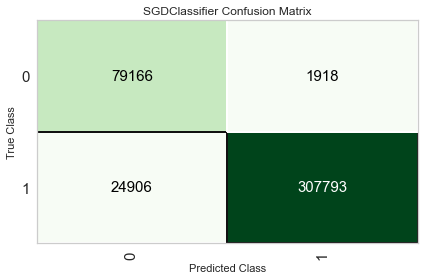

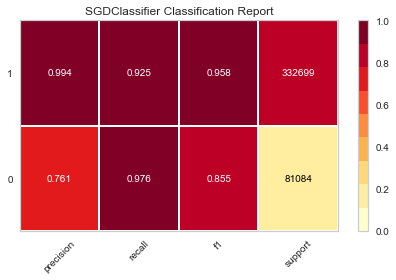

In [12]:
predict_model(svm)
plot_model(svm, plot = 'confusion_matrix')
plot_model(svm, plot = 'class_report')


## Decision Trees

In [13]:
dt = create_model('dt') 
dt_grid = pull()
print(dt_grid)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9224,0.8996,0.9371,0.9654,0.9510,0.7644,0.7664
1,0.9209,0.8980,0.9357,0.9649,0.9501,0.7603,0.7623
2,0.9064,0.8894,0.9173,0.9645,0.9403,0.7238,0.7288
3,0.9442,0.9553,0.9370,0.9932,0.9643,0.8372,0.8446
4,0.9148,0.8952,0.9274,0.9652,0.9459,0.7450,0.7483
5,0.9073,0.8936,0.9161,0.9669,0.9408,0.7279,0.7336
6,0.9235,0.9010,0.9381,0.9658,0.9518,0.7677,0.7696
7,0.9049,0.8870,0.9165,0.9635,0.9394,0.7195,0.7244
8,0.9236,0.9025,0.9372,0.9668,0.9517,0.7685,0.7707


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9224  0.8996  0.9371  0.9654  0.9510  0.7644  0.7664
1       0.9209  0.8980  0.9357  0.9649  0.9501  0.7603  0.7623
2       0.9064  0.8894  0.9173  0.9645  0.9403  0.7238  0.7288
3       0.9442  0.9553  0.9370  0.9932  0.9643  0.8372  0.8446
4       0.9148  0.8952  0.9274  0.9652  0.9459  0.7450  0.7483
5       0.9073  0.8936  0.9161  0.9669  0.9408  0.7279  0.7336
6       0.9235  0.9010  0.9381  0.9658  0.9518  0.7677  0.7696
7       0.9049  0.8870  0.9165  0.9635  0.9394  0.7195  0.7244
8       0.9236  0.9025  0.9372  0.9668  0.9517  0.7685  0.7707
9       0.9234  0.9028  0.9368  0.9670  0.9516  0.7683  0.7705
Mean    0.9191  0.9024  0.9299  0.9683  0.9487  0.7583  0.7619
Std     0.0111  0.0183  0.0092  0.0084  0.0071  0.0322  0.0325


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,0.9999,0.9999


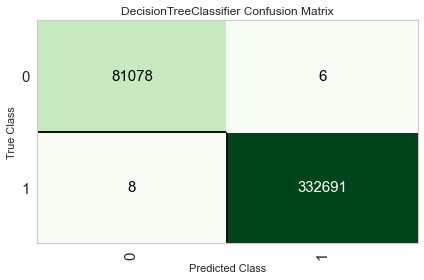

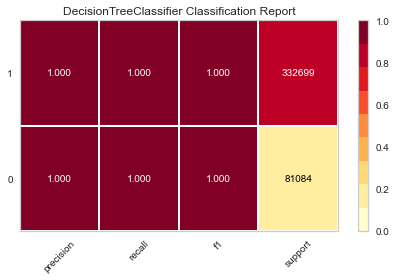

In [14]:
predict_model(dt)
plot_model(dt, plot = 'confusion_matrix')
plot_model(dt, plot = 'class_report')

## Naive Bayes

In [15]:
nb = create_model('nb')
nb_grid = pull()
print(nb_grid)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9665,0.9836,0.9859,0.9728,0.9793,0.8914,0.8920
1,0.9674,0.9837,0.9859,0.9739,0.9799,0.8946,0.8950
2,0.9657,0.9839,0.9851,0.9726,0.9788,0.8888,0.8893
3,0.9675,0.9839,0.9856,0.9743,0.9799,0.8950,0.8954
4,0.9676,0.9848,0.9868,0.9733,0.9800,0.8949,0.8954
5,0.9670,0.9838,0.9859,0.9734,0.9796,0.8930,0.8935
6,0.9674,0.9843,0.9859,0.9739,0.9799,0.8946,0.8951
7,0.9672,0.9833,0.9861,0.9734,0.9797,0.8938,0.8943
8,0.9670,0.9834,0.9863,0.9730,0.9796,0.8932,0.8937


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9665  0.9836  0.9859  0.9728  0.9793  0.8914  0.8920
1       0.9674  0.9837  0.9859  0.9739  0.9799  0.8946  0.8950
2       0.9657  0.9839  0.9851  0.9726  0.9788  0.8888  0.8893
3       0.9675  0.9839  0.9856  0.9743  0.9799  0.8950  0.8954
4       0.9676  0.9848  0.9868  0.9733  0.9800  0.8949  0.8954
5       0.9670  0.9838  0.9859  0.9734  0.9796  0.8930  0.8935
6       0.9674  0.9843  0.9859  0.9739  0.9799  0.8946  0.8951
7       0.9672  0.9833  0.9861  0.9734  0.9797  0.8938  0.8943
8       0.9670  0.9834  0.9863  0.9730  0.9796  0.8932  0.8937
9       0.9665  0.9836  0.9855  0.9731  0.9793  0.8915  0.8919
Mean    0.9670  0.9838  0.9859  0.9734  0.9796  0.8931  0.8936
Std     0.0006  0.0004  0.0004  0.0005  0.0004  0.0019  0.0019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.9671,0.9832,0.9858,0.9736,0.9797,0.8936,0.8940


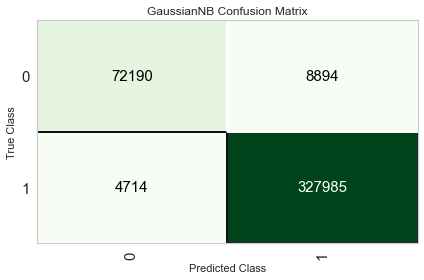

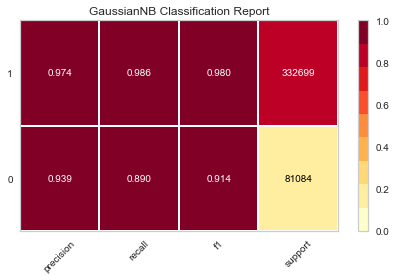

In [16]:
predict_model(nb)
plot_model(nb, plot = 'confusion_matrix')
plot_model(nb, plot = 'class_report')

## Model Explainability

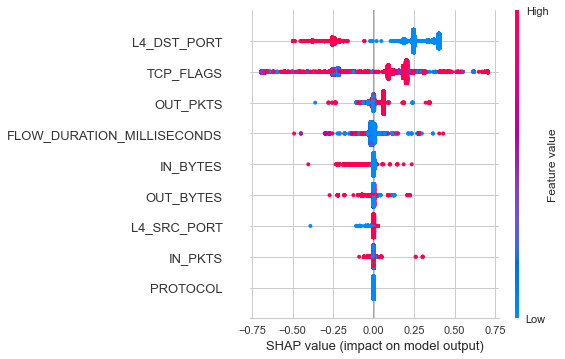

In [17]:
interpret_model(dt)